In [1]:
dataset_name = "rds_cpu_utilization_cc0c53"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 128

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '5min', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '5min', data, method="linear")

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="5min", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-02-25 07:15:00",
                      "2014-02-27 00:50:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-02-14 14:30:00
End date:  2014-02-28 14:30:00
Missing time stamps: 
 DatetimeIndex(['2014-02-25 07:10:00'], dtype='datetime64[ns]', freq='5T')
Fill Missing Time Steps with Interpolation
Length:  4033
Time step size:  5min
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [3081, 3580]


# SARIMA: using own params
# trend but no seasonality -> try brown exponential smoothing

Final parameters:  (0, 2, 2, 0, 0, 0, 0)


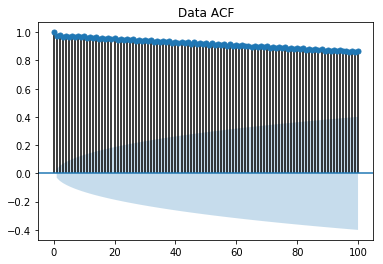

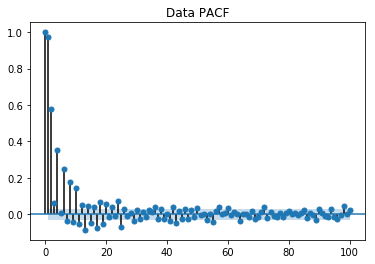

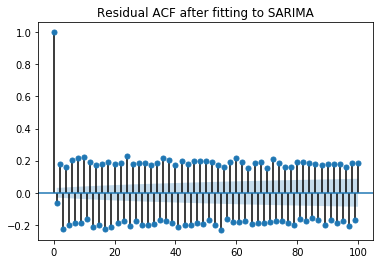

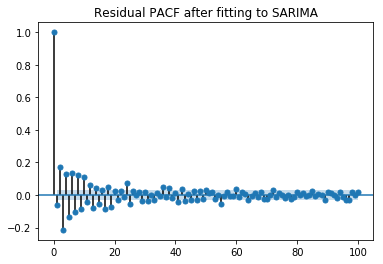

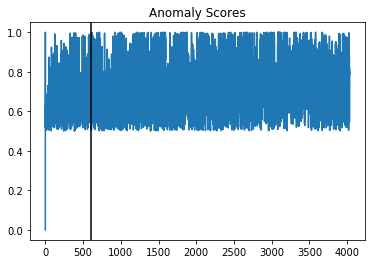

Time:  3.8879754543304443
RMSE:  0.6318847269537188


['anomaly_scores/SARIMA_guide/rds_cpu_utilization_cc0c53']

In [4]:
save_path = "anomaly_scores/SARIMA_guide/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,p=0, d=2, q=2, big_p=0, big_d=0, big_q=0, s=0, plot_anomaly_score=True, plot_acf=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# FB Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


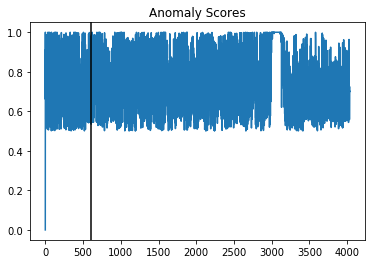

Time:  34.34665608406067
RMSE:  0.8022776209103044


['anomaly_scores/Prophet/rds_cpu_utilization_cc0c53']

In [5]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size,periods=0, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

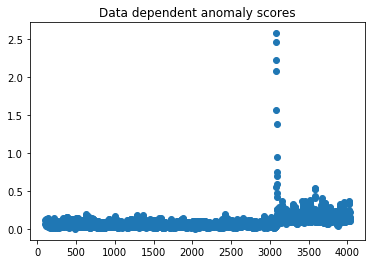

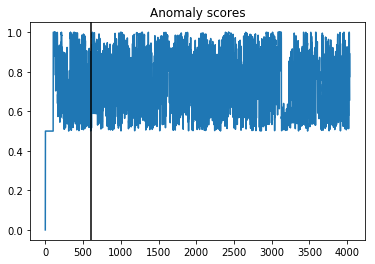

Time:  328.98956084251404


['anomaly_scores/RNN/rds_cpu_utilization_cc0c53']

In [4]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=5, n_test=20, n_epochs=50, n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

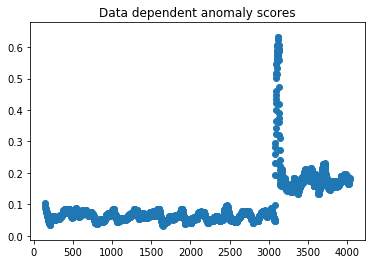

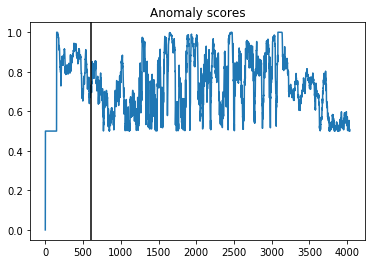

Time:  338.7729859352112


['anomaly_scores/RNN/rds_cpu_utilization_cc0c53']

In [6]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=50, n_test=20, n_epochs=50, n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

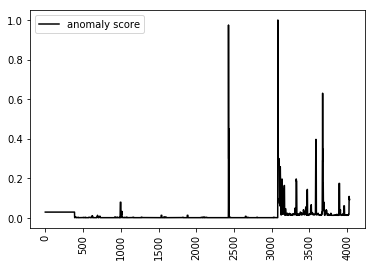

Time:  23.05


['anomaly_scores/HTM/rds_cpu_utilization_cc0c53']

In [7]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"

htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", 23.05)
output_dict = {"Anomaly Scores": anomaly_scores, "Time": 23.05}
joblib.dump(output_dict, save_path)

# Donut

Trainable Parameters              (58,150 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (120,)         120
donut/p_x_given_z/x_mean/kernel  (100, 120)  12,000
donut/p_x_given_z/x_std/bias     (120,)         120
donut/p_x_given_z/x_std/kernel   (100, 120)  12,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (120, 100)  12,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 10, ETA 17.4s] Learning rate decreased to 0

INFO:tensorflow:Restoring parameters from /tmp/tmpl1n98ut1/variables.dat-200


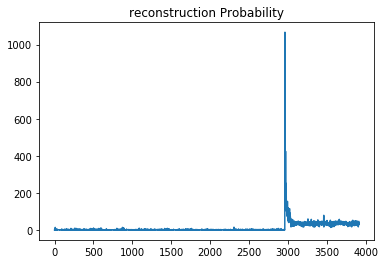

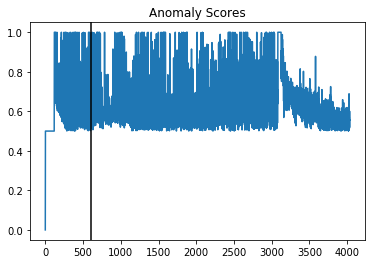

Time:  17.855806350708008


['anomaly_scores/Donut/rds_cpu_utilization_cc0c53']

In [8]:
save_path = "anomaly_scores/Donut/" + dataset_name
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

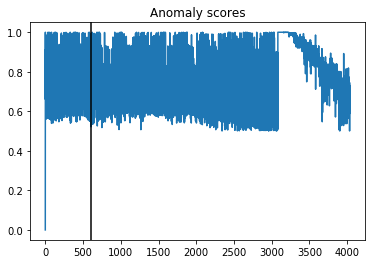

Time:  0.3807389736175537


['anomaly_scores/windowed_gaussian/rds_cpu_utilization_cc0c53']

In [10]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size,plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

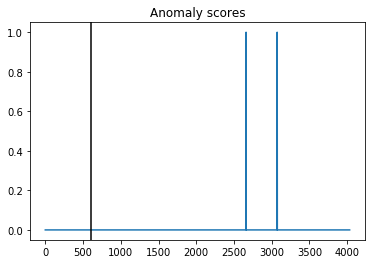

Time:  113.92041635513306


['anomaly_scores/hotsax/rds_cpu_utilization_cc0c53']

In [11]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [12]:
# No sarima: autoarima bc
# ValueError: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
# no twitter bc no seasonality
# no stl bc no seasonality